<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Introduction to image similarity

Image similarity methods can be used to build Image Retrieval systems where, given a query image, the goal is to find all similar images in a reference set. These systems can be used e.g. on a shopping website to suggest related products.

In this tutorial we build an image retrieval system based on leveraging DNNs trained for image classification. Representing images as the output of a DNN is a powerful approach and shown to give good results on a wide variety of tasks. Given a query image, we find the most similar images in the reference set by computing the pairwise distances as illustrated below, and by returning the images with the lowest distance to the query image.

The distance between two images is computed by:
<img src="media/image_similarity_diagram2.jpg" width="600px" />

- Representing each image using the output of a DNN which was pre-trained on millions of images and fine-tuned on images from the same domain. The input to the DNN is an image, and the output is the penultimate layer which, for the ResNet-18 model used in this tutorial, consists of 512-floating point values. Note that we use only a single DNN which takes each of the two images independently as input.
- Normalizing each of the 512-floats DNN image representations (aka. embeddings or features) to be unit vectors, i.e. have an L2 norm of one.
- Finally, obtaining the distance between the two input images by computing the L2 distance between their respective DNN representations.

This notebook starts by loading a dataset and splitting it into a training and a validation set. The training set is used to refine an ImageNet pre-trained ResNet-18 DNN, which is then used to compute the DNN features for each image. The validation set is used in an image retrieval example where, given a query image, the top similar images are displayed. This is followed by a quantitative evaluation of the proposed image similarity system.

## Initialization

In [12]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [13]:
# Regular python libraries
import sys
import numpy as np
from pathlib import Path
import random

import scrapbook as sb

# fast.ai
import fastai
# from fastai.vision import (
#     accuracy,
#     cnn_learner,
#     DatasetType,
#     ImageList,
#     imagenet_stats,
#     models,
#     partial,
#     get_transforms,
#     flip_lr
# )

from fastai.vision import *
from fastai.callbacks.hooks import * 

# Computer Vision repository
sys.path.extend([".", "../.."])  # to access the utils_cv library
from utils_cv.classification.data import Urls
from utils_cv.classification.model import TrainMetricsRecorder
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor, db_num_workers
from utils_cv.similarity.data import comparative_set_builder
from utils_cv.similarity.metrics import (
    compute_distances,
    positive_image_ranks,
    recall_at_k,
)
from utils_cv.similarity.model import compute_features, compute_features_learner
from utils_cv.similarity.plot import (
    plot_comparative_set,
    plot_distances,
    plot_ranks_distribution,
    plot_recalls,
)
from utils_cv.similarity.widget import RetrievalWidget

In [14]:
print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.57
Torch is using GPU: Tesla K80


In [15]:
import torch; print(torch.__version__)

1.2.0


## Data preparation
We start with parameter specifications and data preparation. We use the *Fridge objects* dataset, which is composed of 134 images, divided into 4 classes: can, carton, milk bottle and water bottle. To train your own image retrieval systems, simply change the `DATA_PATH` variable below to point to a different (single-label) dataset.

In [16]:
# Set dataset, model and evaluation parameters
# DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)
DATA_PATH = unzip_url('../../data/limmert_data_3.zip', exist_ok=True)

# DNN configuration and learning parameters
EPOCHS_HEAD = 4
EPOCHS_BODY = 12
LEARNING_RATE = 10* 1e-4
BATCH_SIZE = 16
ARCHITECTURE = models.resnet34
IM_SIZE = 270
IM_SIZE_HALF = IM_SIZE // 2

In [17]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



In [18]:
# tfms = get_transforms(max_rotate= 10.,max_zoom=1., max_lighting=0.20, do_flip=False,
#                       max_warp=0., xtra_tfms=[flip_lr(), brightness(change=(0.3, 0.60), p=0.7), contrast(scale=(0.5, 2), p=0.7),
#                                               crop_pad(size=600, padding_mode='border', row_pct=0.,col_pct=0.),
#                                               rand_zoom(scale=(1.,1.5)), rand_crop(),
#                                               perspective_warp(magnitude=(-0.1,0.1)),
#                                               symmetric_warp(magnitude=(-0.1,0.1)) ])

In [19]:
tfms = get_transforms(max_rotate= 0.,max_zoom=1., max_lighting=0.20, do_flip=False,
                      max_warp=0., xtra_tfms=[flip_lr()])

We can now build our training data object, and split it to get a certain percentage (here 20%) assigned to a validation set.

In [20]:
src = (ImageList.from_folder(DATA_PATH)
        .split_by_rand_pct(0.2, seed=20)
        .label_from_folder())

In [21]:
data = (src.transform(tfms, resize_method=ResizeMethod.SQUISH, padding_mode='reflection', size=IM_SIZE_HALF)
        .databunch(bs=BATCH_SIZE, num_workers=db_num_workers())
        .normalize(imagenet_stats))

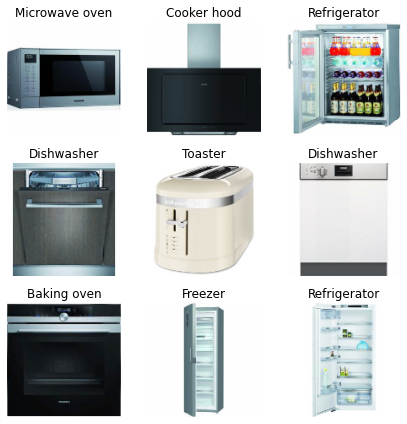

In [22]:
data.show_batch(rows=3, figsize=(6, 6))

In [23]:
print(f'Classes: \n {data.classes}')

Classes: 
 ['Baking oven', 'Coffee maker', 'Cooker hood', 'Cooking pot', 'Dishwasher', 'Espresso machine', 'Freezer', 'Fridge', 'Grill', 'Hair dryer', 'Hob', 'Kitchen machine', 'Microwave oven', 'Refrigerator', 'Slicing machine', 'Toaster']


In [24]:
print(f"""\
Training set: {len(data.train_ds.x)} images
Validation set: {len(data.valid_ds.x)} images\
"""
)

Training set: 1228 images
Validation set: 307 images


In [25]:
# Load images into fast.ai's ImageDataBunch object
# random.seed(642)
# data = (
#     ImageList.from_folder(DATA_PATH)
#     .split_by_rand_pct(valid_pct=0.2, seed=20)
#     .label_from_folder()
#     .transform(size=IM_SIZE)
#     .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
#     .normalize(imagenet_stats)
# )

# print(f"""\
# Training set: {len(data.train_ds.x)} images
# Validation set: {len(data.valid_ds.x)} images\
# """
# )

# # Display example images
# data.show_batch(rows=3, figsize=(6, 6))

## Classification model fine-tuning

We begin by retrieving a [ResNet18](https://arxiv.org/pdf/1512.03385.pdf) CNN from fast.ai's library which is pre-trained on ImageNet, and fine-tune the model on our training set. We use the same training parameters and take the same approach as what we did in our [classification notebooks](https://github.com/microsoft/ComputerVision/tree/master/classification/notebooks), training first the (new) last layer only, and then the full DNN.

Note how we train the DNN here on an image classification task but will use it as featurizer later for image similarity.

In [26]:
learn = cnn_learner(
    data,
    ARCHITECTURE,
    metrics=[accuracy],
#     callback_fns=[partial(TrainMetricsRecorder, show_graph=True)],
    ps=0 #Leave dropout at zero. Higher values tend to perform significantly worse
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 2.75E-03


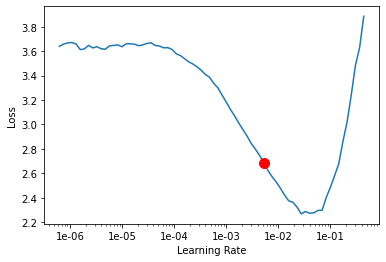

In [27]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

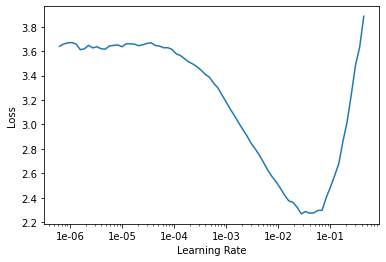

In [28]:
learn.recorder.plot()

In [29]:
lr=3e-02
# learn.fit_one_cycle(2, max_lr=slice(1e-2), wd = (1e-6, 1e-4, 1e-2), pct_start=0.5)

In [30]:
# Train the last layer using a larger rate since most of the DNN is fixed.
learn.fit_one_cycle(EPOCHS_HEAD, lr)

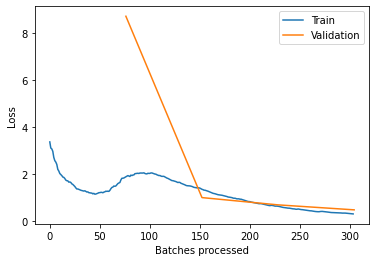

In [31]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 5.25E-06


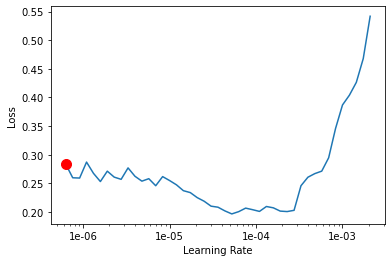

In [32]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

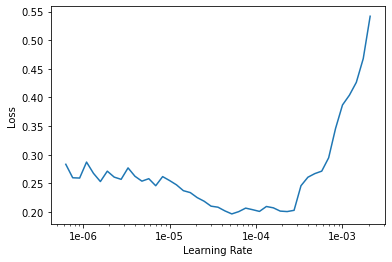

In [33]:
learn.recorder.plot()

Let's now unfreeze all the layers and fine-tuning the model more 

In [34]:
learn.fit_one_cycle(EPOCHS_BODY, slice(1e-05, lr/5))

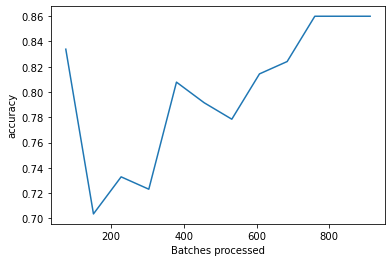

In [35]:
learn.recorder.plot_metrics()

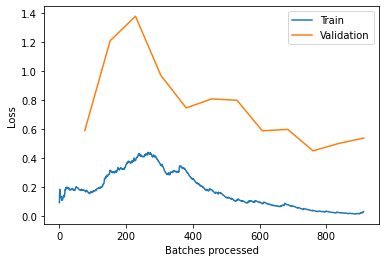

In [36]:
learn.recorder.plot_losses()

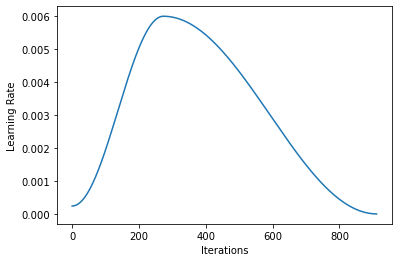

In [37]:
learn.recorder.plot_lr()

In [38]:
data_big = (src.transform(tfms, resize_method=ResizeMethod.SQUISH, padding_mode='reflection', size=IM_SIZE)
        .databunch(bs=BATCH_SIZE, num_workers=db_num_workers())
        .normalize(imagenet_stats))

learn.data = data_big

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 6.92E-03


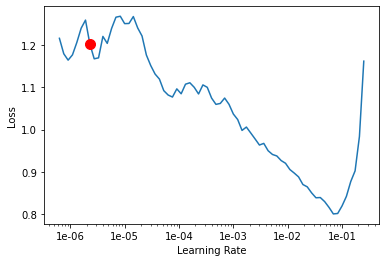

In [39]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [40]:
lr = 1e-3
learn.fit_one_cycle(EPOCHS_HEAD, lr)

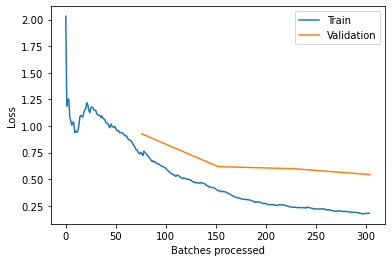

In [41]:
learn.recorder.plot_losses()

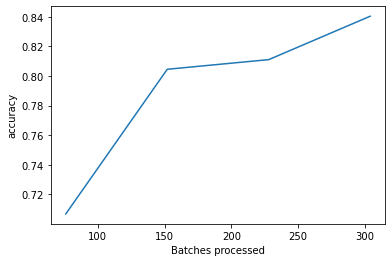

In [42]:
learn.recorder.plot_metrics()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


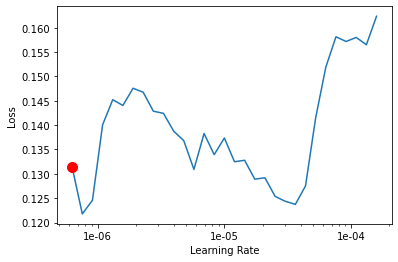

In [43]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [44]:
learn.fit_one_cycle(EPOCHS_BODY, slice(1e-05, lr/5))

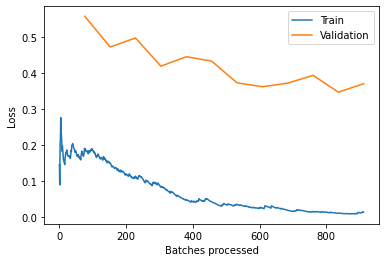

In [45]:
learn.recorder.plot_losses()

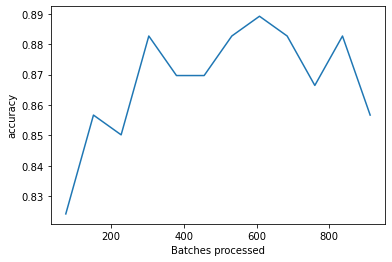

In [46]:
learn.recorder.plot_metrics()

In [47]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data_big.valid_ds)==len(losses)==len(idxs)

True

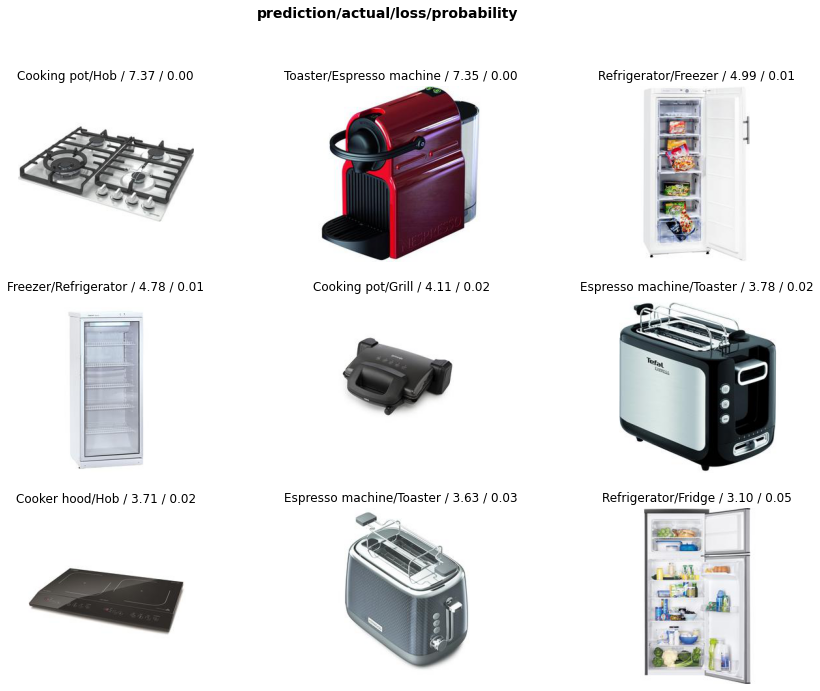

In [48]:
interp.plot_top_losses(9, figsize=(15,11))

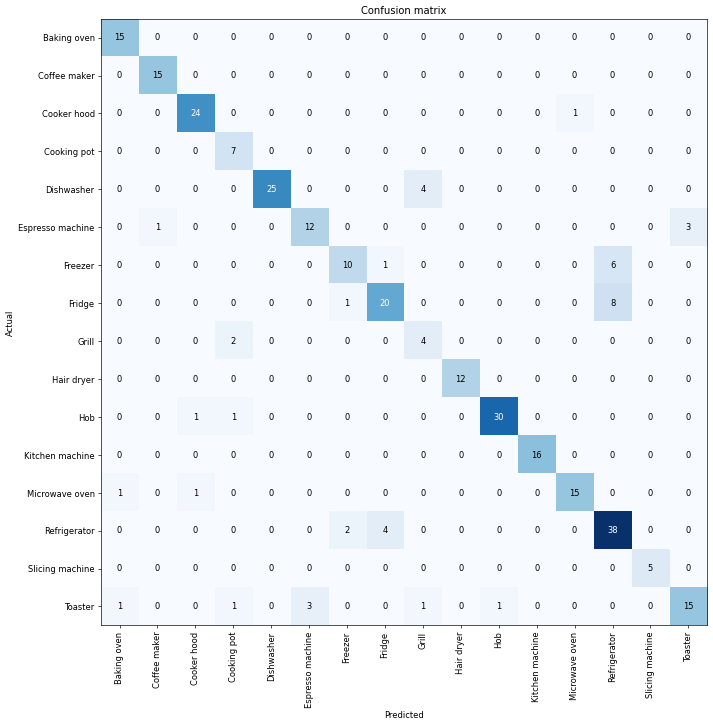

In [49]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [50]:
interp.most_confused(min_val=2)

[('Fridge', 'Refrigerator', 8),
 ('Freezer', 'Refrigerator', 6),
 ('Dishwasher', 'Grill', 4),
 ('Refrigerator', 'Fridge', 4),
 ('Espresso machine', 'Toaster', 3),
 ('Toaster', 'Espresso machine', 3),
 ('Grill', 'Cooking pot', 2),
 ('Refrigerator', 'Freezer', 2)]

In [51]:
learn.save('final_model_3_resnet34_annoy_limmert_data_2')

In [52]:
learn.export('final_model_3_resnet34_annoy_limmert_data_2')

In [51]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## Fastai Hooks

In [52]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [53]:
learn.model[1][-2] 

BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [54]:
sf = SaveFeatures(learn.model[1][4])

In [55]:
_= learn.get_preds(data_big.train_ds)
_= learn.get_preds(DatasetType.Valid)

In [56]:
len(sf.features)

1535

In [57]:
img_path = [str(x) for x in (list(data_big.train_ds.items) +list(data_big.valid_ds.items))]
label = [data_big.classes[x] for x in (list(data_big.train_ds.y.items) +list(data_big.valid_ds.y.items))]
label_id = [x for x in (list(data_big.train_ds.y.items) +list(data_big.valid_ds.y.items))]

In [58]:
len(img_path), len(label), len(label_id)

(1535, 1535, 1535)

In [59]:
df_new = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
# df_new.loc[500:600]
df_new

img_path             label  \
0     /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
1     /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
2     /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
3     /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
4     /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
...                                                 ...               ...   
1530  /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
1531  /home/ec2-user/SageMaker/visual-search-thesis/...  Espresso machine   
1532  /home/ec2-user/SageMaker/visual-search-thesis/...       Cooking pot   
1533  /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
1534  /home/ec2-user/SageMaker/visual-search-thesis/...               Hob   

      label_id  
0           13  
1           13  
2           13  
3           13  
4           13  
...        ...  
1530        13  
1531         5  
1532         3  
1533        13  
1534        10  

[1535 rows x 3 columns]

In [60]:
array = np.array(sf.features)

In [61]:
x=array.tolist()

In [62]:
df_new['img_repr'] = x

In [63]:
df_new

img_path             label  \
0     /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
1     /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
2     /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
3     /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
4     /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
...                                                 ...               ...   
1530  /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
1531  /home/ec2-user/SageMaker/visual-search-thesis/...  Espresso machine   
1532  /home/ec2-user/SageMaker/visual-search-thesis/...       Cooking pot   
1533  /home/ec2-user/SageMaker/visual-search-thesis/...      Refrigerator   
1534  /home/ec2-user/SageMaker/visual-search-thesis/...               Hob   

      label_id                                           img_repr  
0           13  [0.0, 9.920961380004883, 0.0, 3.19765090942382...  
1           13  [0.0, 28.577884674072266, 18.255537033081055, ...  
2           13  [0.0, 4.369209289550781, 0.0, 5.30206441879272...  
3           13  [0.0, 29.768932342529297, 8.761638641357422, 1...  
4           13  [0.0, 12.981230735778809, 13.352237701416016, ...  
...        ...                                                ...  
1530        13  [0.0, 19.719135284423828, 19.651771545410156, ...  
1531         5  [3.9247663021087646, 14.420799255371094, 0.447...  
1532         3  [11.610410690307617, 0.0, 0.0, 8.4506444931030...  
1533        13  [0.0, 30.598939895629883, 5.928018569946289, 1...  
1534        10  [11.630119323730469, 0.0, 0.0, 0.0, 19.4187526...  

[1535 rows x 4 columns]

In [64]:
df_new.to_csv('./df_new.csv')

In [65]:
df_new.shape

(1535, 4)

## Image similarity using Cosine Similarity

In [66]:
from scipy.spatial.distance import cosine
import time

def get_similar_images(img_index, n=10):
    start = time.time()
    base_img_id, base_vector, base_label  = df_new.iloc[img_index, [0, 3, 1]]
    cosine_similarity = 1 - df_new['img_repr'].apply(lambda x: cosine(x, base_vector))
    similar_img_ids = np.argsort(cosine_similarity)[-11:-1][::-1]
    end = time.time()
    print(f'{end - start} secs')
    return base_img_id, base_label, df_new.iloc[similar_img_ids]

In [73]:
# Test 410, 411, 521, 650, 659, 700??, 759??, 765, 1170, 1270, 1370
base_image, base_label, similar_images_df = get_similar_images(565) # 890

0.16137027740478516 secs


Hob
/home/ec2-user/SageMaker/visual-search-thesis/visual-search/data/limmert_data_3/Hob/67.jpg


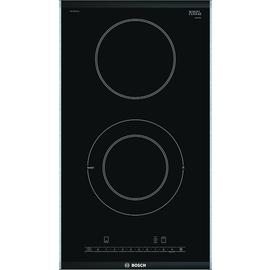

In [74]:
print(base_label)
print(base_image)
open_image(base_image)

In [75]:
similar_images_df

img_path label  label_id  \
525   /home/ec2-user/SageMaker/visual-search-thesis/...   Hob        10   
498   /home/ec2-user/SageMaker/visual-search-thesis/...   Hob        10   
497   /home/ec2-user/SageMaker/visual-search-thesis/...   Hob        10   
545   /home/ec2-user/SageMaker/visual-search-thesis/...   Hob        10   
549   /home/ec2-user/SageMaker/visual-search-thesis/...   Hob        10   
511   /home/ec2-user/SageMaker/visual-search-thesis/...   Hob        10   
1452  /home/ec2-user/SageMaker/visual-search-thesis/...   Hob        10   
523   /home/ec2-user/SageMaker/visual-search-thesis/...   Hob        10   
527   /home/ec2-user/SageMaker/visual-search-thesis/...   Hob        10   
461   /home/ec2-user/SageMaker/visual-search-thesis/...   Hob        10   

                                               img_repr  
525   [13.703712463378906, 0.0, 0.0, 0.0, 7.46813297...  
498   [6.831083297729492, 0.0, 0.0, 0.0, 5.600396156...  
497   [21.98237419128418, 0.0, 0.0, 0.0, 13.75883388...  
545   [24.425537109375, 0.0, 0.0, 0.0, 12.0332584381...  
549   [22.578744888305664, 0.0, 0.0, 0.0, 15.4505281...  
511   [28.508893966674805, 0.0, 0.0, 0.0, 9.92524051...  
1452  [16.832134246826172, 0.0, 0.0, 0.0, 15.6018371...  
523   [31.0756893157959, 0.0, 0.0, 0.0, 10.474748611...  
527   [11.409194946289062, 0.0, 0.0, 0.0, 10.9514951...  
461   [13.958592414855957, 0.0, 0.0, 0.0, 10.6655073...

In [76]:
def show_similar_images(similar_images_df):
    images = [open_image(img_id) for img_id in similar_images_df['img_path']]
    categories = [learn.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learn.data.show_xys(images, categories)

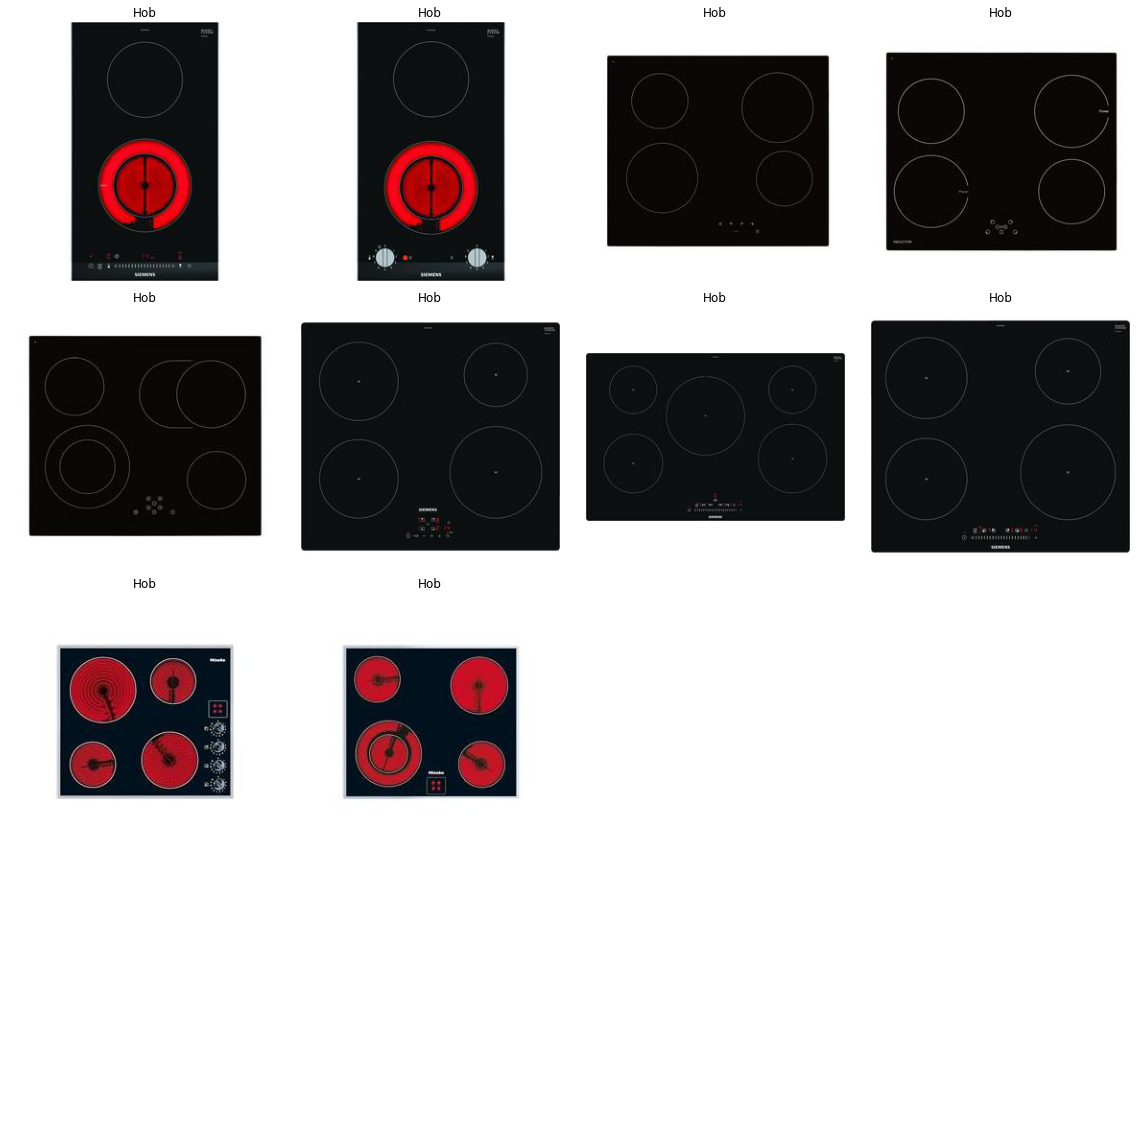

In [77]:
show_similar_images(similar_images_df)

## T-SNE

In [73]:
from sklearn.manifold import TSNE

img_repr_matrix = [list(x) for x in df_new['img_repr'].values]
tsne = TSNE(n_components=3, verbose=10, init='pca', perplexity=30, n_iter=500, n_iter_without_progress=100)
tsne_results_3 = tsne.fit_transform(img_repr_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1623 samples in 0.060s...
[t-SNE] Computed neighbors for 1623 samples in 2.215s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1623
[t-SNE] Computed conditional probabilities for sample 1623 / 1623
[t-SNE] Mean sigma: 7.245058
[t-SNE] Computed conditional probabilities in 0.108s
[t-SNE] Iteration 50: error = 50.6024094, gradient norm = 0.0642569 (50 iterations in 1.382s)
[t-SNE] Iteration 100: error = 50.6372681, gradient norm = 0.0500592 (50 iterations in 1.048s)
[t-SNE] Iteration 150: error = 51.1068497, gradient norm = 0.0410592 (50 iterations in 1.044s)
[t-SNE] Iteration 200: error = 50.8206367, gradient norm = 0.0334062 (50 iterations in 1.029s)
[t-SNE] Iteration 250: error = 51.0032692, gradient norm = 0.0288275 (50 iterations in 1.022s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.003269
[t-SNE] Iteration 300: error = 0.4486356, gradient norm = 0.0006070 (50 iterations in 1.565s)

In [74]:
df_new['tsne1'] = tsne_results_3[:,0]
df_new['tsne2'] = tsne_results_3[:,1]
df_new['tsne3'] = tsne_results_3[:,2]

In [75]:
df_new.to_parquet('similar_images')

In [76]:
pip install plotly_express

Note: you may need to restart the kernel to use updated packages.


In [77]:
import plotly_express as px
px.scatter_3d(df_new, x='tsne1', y='tsne2', z='tsne3', color='label')